In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from matplotlib.patches import Ellipse

In [3]:
def replace_str_to_float(df, parti):

    return df[parti].str.replace(',', '.').astype('float')

In [4]:
def calculate_total_errors(predictions_df, results_df):
    """
    Calculate total absolute error for each respondent
    
    Parameters:
    predictions_df: DataFrame with columns ['respondent', 'party1', 'party2', ...]
    results_df: DataFrame with party names as columns and actual results as values
    
    Returns:
    DataFrame with respondent and total_error columns
    """
    
    # Get party columns (exclude 'respondent' column)
    party_columns = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
    
    # Initialize results
    error_results = []
    
    # Get actual results (assuming results_df has one row with actual percentages)
    actual_results = results_df.iloc[0] if len(results_df) == 1 else results_df
    
    for idx, row in predictions_df.iterrows():
        respondent = row['Eget navn']
        total_error = 0
        
        for party in party_columns:
            if party in actual_results:
                predicted = row[party]
                actual = actual_results[party]
                error = abs(predicted - actual)
                total_error += error
        
        error_results.append({
            'respondent': respondent,
            'total_error': total_error
        })
    
    error_df = pd.DataFrame(error_results)
    error_df = error_df.set_index('respondent')
    return error_df

In [5]:
def calculate_party_errors(predictions_df, results_df):
    """
    Calculate individual party errors for each respondent
    
    Returns:
    - party_errors_df: DataFrame with columns ['respondent'] + party columns (containing absolute errors)
    - party_stats: Summary statistics for each party
    """
    
    # Get party columns (exclude 'respondent' column)
    party_columns = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
    
    # Get actual results (assuming results_df has one row with actual percentages)
    actual_results = results_df.iloc[0] if len(results_df) == 1 else results_df
    
    # Initialize results
    party_errors = []
    
    for idx, row in predictions_df.iterrows():
        error_row = {'respondent': row['Eget navn']}
        
        for party in party_columns:
            if party in actual_results:
                predicted = row[party]
                actual = actual_results[party]
                error = abs(predicted - actual)
                error_row[party] = error
            else:
                error_row[party] = np.nan
        
        party_errors.append(error_row)
    
    party_errors_df = pd.DataFrame(party_errors)
    
    # Calculate summary statistics for each party
    party_stats = {}
    for party in party_columns:
        if party in party_errors_df.columns:
            errors = party_errors_df[party].dropna()
            party_stats[party] = {
                'mean_error': errors.mean(),
                'median_error': errors.median(),
                'std_error': errors.std(),
                'min_error': errors.min(),
                'max_error': errors.max(),
                'actual_result': actual_results[party] if party in actual_results else np.nan
            }
    
    return party_errors_df, party_stats

In [6]:
def create_error_distribution_plots(error_df):
    """
    Create comprehensive error distribution plots
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Total Error Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Histogram with KDE
    axes[0, 0].hist(error_df['total_error'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(error_df['total_error'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {error_df["total_error"].mean():.2f}')
    axes[0, 0].axvline(error_df['total_error'].median(), color='green', linestyle='--', 
                       label=f'Median: {error_df["total_error"].median():.2f}')
    axes[0, 0].set_xlabel('Total Error (percentage points)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Total Prediction Errors')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box plot with individual points
    box_plot = axes[0, 1].boxplot(error_df['total_error'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    
    # Add individual points
    y_points = np.random.normal(1, 0.04, len(error_df))  # Add some jitter
    axes[0, 1].scatter(y_points, error_df['total_error'], alpha=0.6, color='red', s=30)
    
    axes[0, 1].set_ylabel('Total Error (percentage points)')
    axes[0, 1].set_title('Box Plot of Total Errors')
    axes[0, 1].set_xticklabels(['All Respondents'])
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Ranking plot (sorted errors)
    sorted_errors = error_df.sort_values('total_error')
    axes[1, 0].plot(range(len(sorted_errors)), sorted_errors['total_error'], 
                    marker='o', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('Rank (Best to Worst)')
    axes[1, 0].set_ylabel('Total Error (percentage points)')
    axes[1, 0].set_title('Performance Ranking')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Highlight best and worst performers
    best_idx = 0
    worst_idx = len(sorted_errors) - 1
    axes[1, 0].scatter(best_idx, sorted_errors.iloc[best_idx]['total_error'], 
                       color='gold', s=100, label='Best')
    axes[1, 0].scatter(worst_idx, sorted_errors.iloc[worst_idx]['total_error'], 
                       color='red', s=100, label='Worst')
    axes[1, 0].legend()
    
    # 4. Summary statistics
    axes[1, 1].axis('off')
    
    # Calculate statistics
    stats = {
        'Count': len(error_df),
        'Mean Error': f"{error_df['total_error'].mean():.2f}",
        'Median Error': f"{error_df['total_error'].median():.2f}",
        'Std Dev': f"{error_df['total_error'].std():.2f}",
        'Min Error': f"{error_df['total_error'].min():.2f}",
        'Max Error': f"{error_df['total_error'].max():.2f}",
        'Range': f"{error_df['total_error'].max() - error_df['total_error'].min():.2f}"
    }
    
    # Best and worst performers
    best_performer = error_df.loc[error_df['total_error'].idxmin()]
    worst_performer = error_df.loc[error_df['total_error'].idxmax()]
    
    stats_text = "Summary Statistics:\n\n"
    for key, value in stats.items():
        stats_text += f"{key}: {value}\n"

    stats_text += f"\nBest Performer:\n{best_performer.name} ({best_performer['total_error']:.2f})\n"
    stats_text += f"\nWorst Performer:\n{worst_performer.name} ({worst_performer['total_error']:.2f})"
    
    axes[1, 1].text(0.1, 0.95, stats_text, transform=axes[1, 1].transAxes, 
                    fontsize=19, verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    return fig

In [7]:
def create_party_analysis_plots(party_errors_df, party_stats):
    """
    Create comprehensive party-by-party analysis plots
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("tab10")
    
    # Get party columns (exclude respondent)
    party_columns = [col for col in party_errors_df.columns if col != 'respondent']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Party-by-Party Prediction Error Analysis', fontsize=16, fontweight='bold')
    
    # 1. HEATMAP: Respondents vs Parties
    # Prepare data for heatmap (respondents as rows, parties as columns)
    heatmap_data = party_errors_df.set_index('respondent')[party_columns]
    
    # Create heatmap
    im = axes[0, 0].imshow(heatmap_data.values, cmap='Reds', aspect='auto')
    
    # Set labels
    axes[0, 0].set_xticks(range(len(party_columns)))
    axes[0, 0].set_xticklabels(party_columns, rotation=45, ha='right')
    axes[0, 0].set_yticks(range(len(heatmap_data)))
    axes[0, 0].set_yticklabels(heatmap_data.index, fontsize=8)
    axes[0, 0].set_title('Error Heatmap: Darker = Worse Predictions')
    axes[0, 0].set_xlabel('Parties')
    axes[0, 0].set_ylabel('Respondents')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[0, 0])
    cbar.set_label('Absolute Error (percentage points)')
    
    # Add text annotations for values
    for i in range(len(heatmap_data)):
        for j in range(len(party_columns)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                color = 'white' if value > heatmap_data.values.max() * 0.5 else 'black'
                axes[0, 0].text(j, i, f'{value:.1f}', ha='center', va='center', 
                               color=color, fontsize=6, fontweight='bold')
    
    # 2. VIOLIN PLOTS: Distribution of errors by party
    # Prepare data for violin plot
    violin_data = []
    violin_labels = []
    
    for party in party_columns:
        if party in party_errors_df.columns:
            errors = party_errors_df[party].dropna()
            violin_data.append(errors)
            violin_labels.append(f"{party}\n(avg: {errors.mean():.1f})")
    
    # Create violin plot
    parts = axes[0, 1].violinplot(violin_data, positions=range(len(violin_data)), 
                                  showmeans=True, showmedians=True)
    
    # Color the violins
    colors = plt.cm.Set3(np.linspace(0, 1, len(violin_data)))
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    axes[0, 1].set_xticks(range(len(violin_labels)))
    axes[0, 1].set_xticklabels(violin_labels, rotation=45, ha='right', fontsize=9)
    axes[0, 1].set_ylabel('Absolute Error (percentage points)')
    axes[0, 1].set_title('Error Distribution by Party')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. BAR CHART: Average error by party (sorted)
    # Prepare data for bar chart
    party_avg_errors = [(party, party_stats[party]['mean_error']) 
                       for party in party_columns if party in party_stats]
    party_avg_errors.sort(key=lambda x: x[1], reverse=True)  # Sort by error (hardest first)
    
    parties_sorted = [x[0] for x in party_avg_errors]
    errors_sorted = [x[1] for x in party_avg_errors]
    
    bars = axes[1, 0].bar(range(len(parties_sorted)), errors_sorted, 
                         color=plt.cm.Reds(np.linspace(0.3, 0.8, len(parties_sorted))))
    
    axes[1, 0].set_xticks(range(len(parties_sorted)))
    axes[1, 0].set_xticklabels(parties_sorted, rotation=45, ha='right')
    axes[1, 0].set_ylabel('Average Absolute Error')
    axes[1, 0].set_title('Hardest Parties to Predict (Highest Avg Error)')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                       f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. SUMMARY TABLE: Party statistics
    axes[1, 1].axis('off')
    
    # Create summary table
    table_data = []
    headers = ['Party', 'Actual %', 'Avg Error', 'Std Dev', 'Worst Error']
    
    for party in parties_sorted:  # Use same order as bar chart
        stats = party_stats[party]
        table_data.append([
            party,
            f"{stats['actual_result']:.1f}%",
            f"{stats['mean_error']:.1f}",
            f"{stats['std_error']:.1f}",
            f"{stats['max_error']:.1f}"
        ])
    
    # Create table
    table = axes[1, 1].table(cellText=table_data, colLabels=headers, 
                            cellLoc='center', loc='center',
                            colWidths=[0.15, 0.12, 0.12, 0.12, 0.12])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2)
    
    # Color code the table rows by difficulty (matching bar chart colors)
    colors_normalized = plt.cm.Reds(np.linspace(0.3, 0.8, len(parties_sorted)))
    for i in range(len(table_data)):
        for j in range(len(headers)):
            table[(i+1, j)].set_facecolor(colors_normalized[i])
            table[(i+1, j)].set_alpha(0.3)
    
    # Header styling
    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#40466e')
        table[(0, j)].set_text_props(weight='bold', color='white')
    
    axes[1, 1].set_title('Party Prediction Difficulty Rankings', pad=20, fontweight='bold')
    
    plt.tight_layout()
    return fig, party_stats


In [8]:
def get_party_insights(party_errors_df, party_stats):
    """
    Generate text insights about party prediction patterns
    """
    party_columns = [col for col in party_errors_df.columns if col != 'respondent']
    
    # Find hardest and easiest parties
    party_difficulties = [(party, party_stats[party]['mean_error']) 
                         for party in party_columns if party in party_stats]
    party_difficulties.sort(key=lambda x: x[1])
    
    easiest_party = party_difficulties[0]
    hardest_party = party_difficulties[-1]
    
    # Find most consistent/inconsistent parties (by std dev)
    party_consistency = [(party, party_stats[party]['std_error']) 
                        for party in party_columns if party in party_stats]
    party_consistency.sort(key=lambda x: x[1])
    
    most_consistent = party_consistency[0]
    least_consistent = party_consistency[-1]
    
    # Find who was best/worst at hardest party
    hardest_party_name = hardest_party[0]
    hardest_party_errors = party_errors_df[['respondent', hardest_party_name]].copy()
    best_at_hardest = hardest_party_errors.loc[hardest_party_errors[hardest_party_name].idxmin()]
    worst_at_hardest = hardest_party_errors.loc[hardest_party_errors[hardest_party_name].idxmax()]
    
    insights = f"""
PARTY PREDICTION INSIGHTS:

🎯 EASIEST TO PREDICT: {easiest_party[0]} (avg error: {easiest_party[1]:.1f})
😰 HARDEST TO PREDICT: {hardest_party[0]} (avg error: {hardest_party[1]:.1f})

📊 MOST CONSISTENT PREDICTIONS: {most_consistent[0]} (std: {most_consistent[1]:.1f})
📈 MOST INCONSISTENT PREDICTIONS: {least_consistent[0]} (std: {least_consistent[1]:.1f})

🏆 BEST AT HARDEST PARTY ({hardest_party_name}): {best_at_hardest['respondent']} ({best_at_hardest[hardest_party_name]:.1f} error)
🤦 WORST AT HARDEST PARTY ({hardest_party_name}): {worst_at_hardest['respondent']} ({worst_at_hardest[hardest_party_name]:.1f} error)

DIFFICULTY RANKING (hardest first):
"""
    
    party_difficulties.reverse()  # Hardest first
    for i, (party, avg_error) in enumerate(party_difficulties, 1):
        actual_pct = party_stats[party]['actual_result']
        insights += f"{i}. {party}: {avg_error:.1f} avg error (actual: {actual_pct:.1f}%)\n"
    
    return insights


In [9]:
def calculate_prediction_bias(predictions_df, results_df):
    """
    Calculate prediction bias for each party and respondent
    
    Returns:
    - bias_df: DataFrame with signed errors (positive = overestimated, negative = underestimated)
    - party_bias_stats: Overall bias statistics by party
    - respondent_bias_stats: Individual bias patterns by respondent
    """
    
    # Get party columns
    party_columns = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
    
    # Get actual results
    actual_results = results_df.iloc[0] if len(results_df) == 1 else results_df
    
    # Calculate signed errors (predicted - actual)
    bias_data = []
    
    for idx, row in predictions_df.iterrows():
        bias_row = {'respondent': row['Eget navn']}
        
        for party in party_columns:
            if party in actual_results:
                predicted = row[party]
                actual = actual_results[party]
                bias = predicted - actual  # Positive = overestimated, Negative = underestimated
                bias_row[party] = bias
            else:
                bias_row[party] = np.nan
        
        bias_data.append(bias_row)
    
    bias_df = pd.DataFrame(bias_data)
    
    # Calculate party bias statistics
    party_bias_stats = {}
    for party in party_columns:
        if party in bias_df.columns:
            biases = bias_df[party].dropna()
            party_bias_stats[party] = {
                'mean_bias': biases.mean(),
                'median_bias': biases.median(),
                'std_bias': biases.std(),
                'overestimated_count': (biases > 0).sum(),
                'underestimated_count': (biases < 0).sum(),
                'perfect_count': (biases == 0).sum(),
                'actual_result': actual_results[party] if party in actual_results else np.nan
            }
    
    # Calculate respondent bias patterns
    respondent_bias_stats = {}
    for idx, row in bias_df.iterrows():
        respondent = row['respondent']
        biases = row[party_columns].dropna()
        
        respondent_bias_stats[respondent] = {
            'mean_bias': biases.mean(),
            'positive_bias_count': (biases > 0).sum(),
            'negative_bias_count': (biases < 0).sum(),
            'total_predictions': len(biases),
            'optimism_ratio': (biases > 0).sum() / len(biases) if len(biases) > 0 else 0
        }
    
    return bias_df, party_bias_stats, respondent_bias_stats

In [10]:
def create_bias_detection_plots(bias_df, party_bias_stats, respondent_bias_stats, predictions_df, results_df):
    """
    Create comprehensive bias detection visualizations
    """
    
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("RdBu_r")  # Red-Blue colormap for bias
    
    # Get data
    party_columns = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
    actual_results = results_df.iloc[0] if len(results_df) == 1 else results_df
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Prediction Bias Detection Analysis', fontsize=16, fontweight='bold')
    
    # 1. SCATTER PLOT: Predicted vs Actual for each party
    colors = plt.cm.Set1(np.linspace(0, 1, len(party_columns)))
    
    for i, party in enumerate(party_columns):
        if party in actual_results:
            actual_val = actual_results[party]
            predicted_vals = predictions_df[party]
            
            axes[0, 0].scatter(predicted_vals, [actual_val] * len(predicted_vals), 
                             alpha=0.6, s=60, color=colors[i], label=party, 
                             edgecolors='black', linewidth=0.5)
    
    # Add perfect prediction line (diagonal)
    min_val = min(predictions_df[party_columns].min().min(), actual_results.min())
    max_val = max(predictions_df[party_columns].max().max(), actual_results.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, 
                   linewidth=2, label='Perfect Prediction')
    
    axes[0, 0].set_xlabel('Predicted %')
    axes[0, 0].set_ylabel('Actual %')
    axes[0, 0].set_title('Predicted vs Actual Results by Party')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add bias annotations
    for party in party_columns:
        if party in actual_results:
            actual_val = actual_results[party]
            mean_predicted = predictions_df[party].mean()
            bias = mean_predicted - actual_val
            
            # Add arrow showing bias direction
            if abs(bias) > 0.5:  # Only show significant biases
                color = 'red' if bias > 0 else 'blue'
                axes[0, 0].annotate(f'{party}\n({bias:+.1f})', 
                                  xy=(actual_val, actual_val),
                                  xytext=(mean_predicted, actual_val),
                                  arrowprops=dict(arrowstyle='->', color=color, lw=2),
                                  fontsize=8, ha='center',
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))
    
    # 2. BAR CHART: Average bias by party
    parties = list(party_bias_stats.keys())
    mean_biases = [party_bias_stats[party]['mean_bias'] for party in parties]
    
    # Color bars by bias direction
    colors = ['red' if bias > 0 else 'blue' if bias < 0 else 'gray' for bias in mean_biases]
    
    bars = axes[0, 1].bar(range(len(parties)), mean_biases, color=colors, alpha=0.7, 
                         edgecolor='black', linewidth=0.5)
    
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[0, 1].set_xticks(range(len(parties)))
    axes[0, 1].set_xticklabels(parties, rotation=45, ha='right')
    axes[0, 1].set_ylabel('Average Bias (Predicted - Actual)')
    axes[0, 1].set_title('Systematic Bias by Party\n(Red = Overestimated, Blue = Underestimated)')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, bias) in enumerate(zip(bars, mean_biases)):
        height = bar.get_height()
        label_y = height + (0.1 if height >= 0 else -0.2)
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., label_y,
                       f'{bias:+.1f}', ha='center', va='bottom' if height >= 0 else 'top',
                       fontweight='bold', fontsize=9)
    
    # 3. INDIVIDUAL BIAS PATTERNS: Heatmap of respondent biases
    # Create bias heatmap data
    bias_heatmap_data = bias_df.set_index('respondent')[party_columns]
    
    # Create custom colormap centered at 0
    from matplotlib.colors import TwoSlopeNorm
    vmin, vmax = bias_heatmap_data.min().min(), bias_heatmap_data.max().max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    im = axes[1, 0].imshow(bias_heatmap_data.values, cmap='RdBu_r', norm=norm, aspect='auto')
    
    # Set labels
    axes[1, 0].set_xticks(range(len(party_columns)))
    axes[1, 0].set_xticklabels(party_columns, rotation=45, ha='right')
    axes[1, 0].set_yticks(range(len(bias_heatmap_data)))
    axes[1, 0].set_yticklabels(bias_heatmap_data.index, fontsize=8)
    axes[1, 0].set_title('Individual Bias Patterns\n(Red = Overestimated, Blue = Underestimated)')
    axes[1, 0].set_xlabel('Parties')
    axes[1, 0].set_ylabel('Respondents')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 0])
    cbar.set_label('Bias (Predicted - Actual)')
    
    # Add text annotations
    for i in range(len(bias_heatmap_data)):
        for j in range(len(party_columns)):
            value = bias_heatmap_data.iloc[i, j]
            if not np.isnan(value):
                color = 'white' if abs(value) > max(abs(vmin), abs(vmax)) * 0.5 else 'black'
                axes[1, 0].text(j, i, f'{value:+.1f}', ha='center', va='center',
                               color=color, fontsize=6, fontweight='bold')
    
    # 4. RESPONDENT BIAS SUMMARY: Who's optimistic/pessimistic?
    axes[1, 1].axis('off')
    
    # Calculate optimism ranking
    respondent_optimism = [(name, stats['mean_bias'], stats['optimism_ratio']) 
                          for name, stats in respondent_bias_stats.items()]
    respondent_optimism.sort(key=lambda x: x[1], reverse=True)  # Most optimistic first
    
    # Create summary text
    summary_text = "INDIVIDUAL BIAS PATTERNS:\n\n"
    summary_text += "MOST OPTIMISTIC (Overestimators):\n"
    
    for i, (name, mean_bias, opt_ratio) in enumerate(respondent_optimism[:3]):
        summary_text += f"{i+1}. {name}: {mean_bias:+.1f} avg bias ({opt_ratio:.0%} overestimates)\n"
    
    summary_text += "MOST PESSIMISTIC (Underestimators):\n"
    for i, (name, mean_bias, opt_ratio) in enumerate(respondent_optimism[-3:]):
        summary_text += f"{i+1}. {name}: {mean_bias:+.1f} avg bias ({(1-opt_ratio):.0%} underestimates)\n"
    
    # Party bias summary
    party_overest = [(party, stats['mean_bias']) for party, stats in party_bias_stats.items() 
                     if stats['mean_bias'] > 0.5]
    party_underest = [(party, stats['mean_bias']) for party, stats in party_bias_stats.items() 
                      if stats['mean_bias'] < -0.5]
    
    summary_text += "MOST OVERESTIMATED PARTIES:\n"
    party_overest.sort(key=lambda x: x[1], reverse=True)
    for party, bias in party_overest[:3]:
        pct_over = party_bias_stats[party]['overestimated_count'] / len(predictions_df) * 100
        summary_text += f"• {party}: {bias:+.1f} avg ({pct_over:.0f}% overestimated it)\n"
    
    summary_text += "MOST UNDERESTIMATED PARTIES:\n"
    party_underest.sort(key=lambda x: x[1])
    for party, bias in party_underest[:3]:
        pct_under = party_bias_stats[party]['underestimated_count'] / len(predictions_df) * 100
        summary_text += f"• {party}: {bias:+.1f} avg ({pct_under:.0f}% underestimated it)\n"
    
    # Add the text
    axes[1, 1].text(-0.05, 0.95, summary_text, transform=axes[1, 1].transAxes,
                   fontsize=19, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    return fig

In [11]:
def get_bias_insights(bias_df, party_bias_stats, respondent_bias_stats):
    """
    Generate detailed bias analysis insights
    """
    
    insights = "🎯 BIAS DETECTION INSIGHTS:\n\n"
    
    # Overall bias trends
    party_columns = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
    overall_bias = bias_df[party_columns].mean().mean()
    
    if abs(overall_bias) < 0.1:
        insights += f"📊 OVERALL: Group predictions were remarkably unbiased (avg: {overall_bias:+.2f})\n"
    elif overall_bias > 0:
        insights += f"📈 OVERALL: Group tends to be optimistic/overestimate parties (avg: {overall_bias:+.1f})\n"
    else:
        insights += f"📉 OVERALL: Group tends to be pessimistic/underestimate parties (avg: {overall_bias:+.1f})\n"
    
    # Find most biased predictions
    most_overestimated = max(party_bias_stats.items(), key=lambda x: x[1]['mean_bias'])
    most_underestimated = min(party_bias_stats.items(), key=lambda x: x[1]['mean_bias'])
    
    insights += f"\n🔴 BIGGEST OVERESTIMATE: {most_overestimated[0]} "
    insights += f"({most_overestimated[1]['mean_bias']:+.1f} on average)\n"
    insights += f"   → {most_overestimated[1]['overestimated_count']}/{len(bias_df)} people overestimated it\n"
    
    insights += f"\n🔵 BIGGEST UNDERESTIMATE: {most_underestimated[0]} "
    insights += f"({most_underestimated[1]['mean_bias']:+.1f} on average)\n"
    insights += f"   → {most_underestimated[1]['underestimated_count']}/{len(bias_df)} people underestimated it\n"
    
    # Individual patterns
    most_optimistic = max(respondent_bias_stats.items(), key=lambda x: x[1]['mean_bias'])
    most_pessimistic = min(respondent_bias_stats.items(), key=lambda x: x[1]['mean_bias'])
    
    insights += f"\n😊 MOST OPTIMISTIC PERSON: {most_optimistic[0]} "
    insights += f"({most_optimistic[1]['mean_bias']:+.1f} avg bias)\n"
    
    insights += f"😔 MOST PESSIMISTIC PERSON: {most_pessimistic[0]} "
    insights += f"({most_pessimistic[1]['mean_bias']:+.1f} avg bias)\n"
    
    return insights

In [12]:
def prepare_clustering_data(predictions_df):
    """
    Prepare prediction data for clustering analysis
    """
    # Get party columns (exclude 'respondent' column)
    party_columns = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
    
    # Create feature matrix (respondents as rows, parties as columns)
    X = predictions_df[party_columns].values
    respondent_names = predictions_df['Eget navn'].tolist()
    
    # Standardize the data (important for clustering)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X, X_scaled, respondent_names, party_columns

In [13]:
def perform_clustering(X_scaled, respondent_names, n_clusters=3):
    """
    Perform multiple types of clustering analysis
    """
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X_scaled)
    
    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # t-SNE for non-linear dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(respondent_names)-1))
    X_tsne = tsne.fit_transform(X_scaled)
    
    return {
        'kmeans_labels': kmeans_labels,
        'hierarchical_labels': hierarchical_labels,
        'X_pca': X_pca,
        'X_tsne': X_tsne,
        'pca': pca,
        'tsne': tsne
    }

In [14]:
def calculate_similarity_network(X, respondent_names, threshold_percentile=75):
    """
    Create a similarity network between respondents
    """
    # Calculate pairwise distances (using correlation for similarity)
    correlation_matrix = np.corrcoef(X)
    
    # Convert correlation to distance (1 - correlation)
    distance_matrix = 1 - np.abs(correlation_matrix)
    
    # Create similarity matrix (higher = more similar)
    similarity_matrix = 1 - distance_matrix
    
    # Create network graph
    G = nx.Graph()
    
    # Add nodes
    for name in respondent_names:
        G.add_node(name)
    
    # Add edges for similar respondents (above threshold)
    threshold = np.percentile(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)], 
                             threshold_percentile)
    
    for i, name1 in enumerate(respondent_names):
        for j, name2 in enumerate(respondent_names[i+1:], i+1):
            similarity = similarity_matrix[i, j]
            if similarity > threshold:
                G.add_edge(name1, name2, weight=similarity)
    
    return G, similarity_matrix, correlation_matrix

In [15]:
def create_political_clustering_plots(predictions_df, n_clusters=3):
    """
    Create comprehensive political clustering visualizations
    """
    
    # Prepare data
    X, X_scaled, respondent_names, party_columns = prepare_clustering_data(predictions_df)
    
    # Perform clustering
    clustering_results = perform_clustering(X_scaled, respondent_names, n_clusters)
    
    # Calculate similarity network
    G, similarity_matrix, correlation_matrix = calculate_similarity_network(X, respondent_names)
    
    # Set up plotting
    plt.style.use('default')
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Political Clustering Analysis: Who Thinks Alike?', fontsize=16, fontweight='bold')
    
    # 1. PCA CLUSTERING (Top Left)
    X_pca = clustering_results['X_pca']
    kmeans_labels = clustering_results['kmeans_labels']
    pca = clustering_results['pca']
    
    # Plot PCA with clusters
    for i in range(n_clusters):
        cluster_mask = kmeans_labels == i
        axes[0, 0].scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
                          c=[colors[i]], s=100, alpha=0.7, 
                          label=f'Cluster {i+1}', edgecolors='black', linewidth=0.5)
        
        # Add confidence ellipse for each cluster
        if np.sum(cluster_mask) > 2:  # Need at least 3 points for ellipse
            cluster_points = X_pca[cluster_mask]
            mean = cluster_points.mean(axis=0)
            cov = np.cov(cluster_points.T)
            
            # Calculate ellipse parameters
            eigenvals, eigenvecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
            width, height = 2 * np.sqrt(eigenvals) * 2  # 2 sigma
            
            ellipse = Ellipse(mean, width, height, angle=angle, 
                            facecolor=colors[i], alpha=0.2, edgecolor=colors[i])
            axes[0, 0].add_patch(ellipse)
    
    # Add names to points
    for i, name in enumerate(respondent_names):
        axes[0, 0].annotate(name, (X_pca[i, 0], X_pca[i, 1]), 
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, ha='left')
    
    axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0, 0].set_title('PCA Clustering: Similar Prediction Patterns')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. t-SNE CLUSTERING (Top Right)
    X_tsne = clustering_results['X_tsne']
    
    for i in range(n_clusters):
        cluster_mask = kmeans_labels == i
        axes[0, 1].scatter(X_tsne[cluster_mask, 0], X_tsne[cluster_mask, 1], 
                          c=[colors[i]], s=100, alpha=0.7, 
                          label=f'Cluster {i+1}', edgecolors='black', linewidth=0.5)
    
    # Add names to points
    for i, name in enumerate(respondent_names):
        axes[0, 1].annotate(name, (X_tsne[i, 0], X_tsne[i, 1]), 
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, ha='left')
    
    axes[0, 1].set_xlabel('t-SNE Dimension 1')
    axes[0, 1].set_ylabel('t-SNE Dimension 2')
    axes[0, 1].set_title('t-SNE Clustering: Non-linear Similarity Detection')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. HIERARCHICAL CLUSTERING DENDROGRAM (Bottom Left)
    # Calculate linkage matrix
    linkage_matrix = linkage(X_scaled, method='ward')
    
    # Create dendrogram
    dendro = dendrogram(linkage_matrix, labels=respondent_names, 
                       ax=axes[1, 0], orientation='top', 
                       color_threshold=0.7*max(linkage_matrix[:,2]))
    
    axes[1, 0].set_title('Hierarchical Clustering Dendrogram\n(Lower = More Similar)')
    axes[1, 0].set_ylabel('Distance')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. SIMILARITY NETWORK (Bottom Right)
    if len(G.edges()) > 0:  # Only if we have connections
        # Calculate layout
        pos = nx.spring_layout(G, k=1, iterations=50)
        
        # Draw network
        nx.draw_networkx_nodes(G, pos, ax=axes[1, 1], 
                              node_color=[colors[kmeans_labels[respondent_names.index(node)]] 
                                        for node in G.nodes()],
                              node_size=300, alpha=0.8)
        
        # Draw edges with thickness based on similarity
        edges = G.edges(data=True)
        weights = [edge[2]['weight'] for edge in edges]
        nx.draw_networkx_edges(G, pos, ax=axes[1, 1], 
                              width=[w*3 for w in weights], 
                              alpha=0.6, edge_color='gray')
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, ax=axes[1, 1], font_size=8)
        
        axes[1, 1].set_title('Similarity Network\n(Thick lines = Very similar predictions)')
    else:
        axes[1, 1].text(0.5, 0.5, 'No strong similarities detected\n(Everyone predicted quite differently)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        axes[1, 1].set_title('Similarity Network')
    
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    return fig, clustering_results, G, similarity_matrix, correlation_matrix


In [16]:
def analyze_cluster_characteristics(predictions_df, clustering_results, party_columns):
    """
    Analyze what makes each cluster unique
    """
    
    X, X_scaled, respondent_names, _ = prepare_clustering_data(predictions_df)
    kmeans_labels = clustering_results['kmeans_labels']
    
    cluster_analysis = {}
    
    for cluster_id in np.unique(kmeans_labels):
        cluster_mask = kmeans_labels == cluster_id
        cluster_members = [respondent_names[i] for i in range(len(respondent_names)) if cluster_mask[i]]
        
        # Calculate cluster centroid (average predictions)
        cluster_data = X[cluster_mask]
        cluster_mean = cluster_data.mean(axis=0)
        
        # Find parties this cluster over/under-estimates compared to overall average
        overall_mean = X.mean(axis=0)
        relative_bias = cluster_mean - overall_mean
        
        # Rank parties by how much this cluster differs from average
        party_deviations = [(party_columns[i], relative_bias[i]) for i in range(len(party_columns))]
        party_deviations.sort(key=lambda x: abs(x[1]), reverse=True)
        
        cluster_analysis[cluster_id] = {
            'members': cluster_members,
            'size': len(cluster_members),
            'average_predictions': dict(zip(party_columns, cluster_mean)),
            'relative_bias': dict(zip(party_columns, relative_bias)),
            'top_deviations': party_deviations[:3],  # Top 3 distinctive characteristics
            'cluster_variance': cluster_data.var(axis=0).mean()  # Internal consistency
        }
    
    return cluster_analysis


In [17]:
def get_clustering_insights(predictions_df, clustering_results, cluster_analysis, correlation_matrix, respondent_names):
    """
    Generate text insights about the clustering patterns
    """
    
    insights = "🎭 POLITICAL CLUSTERING INSIGHTS:\n\n"
    
    # Overall clustering quality
    pca = clustering_results['pca']
    explained_var = sum(pca.explained_variance_ratio_)
    
    insights += f"📊 PCA Analysis: First 2 components explain {explained_var:.1%} of prediction variance\n"
    if explained_var > 0.7:
        insights += "   → Strong clustering patterns detected!\n"
    elif explained_var > 0.5:
        insights += "   → Moderate clustering patterns found\n"
    else:
        insights += "   → Weak clustering - predictions are quite diverse\n"
    
    # Cluster characteristics
    n_clusters = len(cluster_analysis)
    insights += f"\n🎯 Found {n_clusters} distinct prediction groups:\n\n"
    
    cluster_names = ["The Realists", "The Optimists", "The Contrarians", "The Cautious", "The Wildcards"]
    
    for cluster_id, analysis in cluster_analysis.items():
        name = cluster_names[cluster_id] if cluster_id < len(cluster_names) else f"Group {cluster_id+1}"
        insights += f"🎭 {name} ({analysis['size']} members):\n"
        insights += f"   Members: {', '.join(analysis['members'])}\n"
        
        # Top deviations
        insights += f"   Distinctive traits:\n"
        for party, deviation in analysis['top_deviations']:
            direction = "higher" if deviation > 0 else "lower"
            insights += f"   • Predicts {party} {abs(deviation):.1f}pp {direction} than average\n"
        
        consistency = "very consistent" if analysis['cluster_variance'] < 1 else "somewhat varied" if analysis['cluster_variance'] < 3 else "quite diverse"
        insights += f"   Internal consistency: {consistency}\n\n"
    
    # Find most similar pair
    np.fill_diagonal(correlation_matrix, -1)  # Ignore self-correlation
    most_similar_idx = np.unravel_index(np.argmax(correlation_matrix), correlation_matrix.shape)
    most_similar_corr = correlation_matrix[most_similar_idx]
    most_similar_pair = (respondent_names[most_similar_idx[0]], respondent_names[most_similar_idx[1]])
    
    insights += f"👯 MOST SIMILAR PREDICTORS: {most_similar_pair[0]} & {most_similar_pair[1]} "
    insights += f"(correlation: {most_similar_corr:.3f})\n"
    
    # Find least similar pair
    most_different_idx = np.unravel_index(np.argmin(correlation_matrix), correlation_matrix.shape)
    most_different_corr = correlation_matrix[most_different_idx]
    most_different_pair = (respondent_names[most_different_idx[0]], respondent_names[most_different_idx[1]])
    
    insights += f"🔄 MOST DIFFERENT PREDICTORS: {most_different_pair[0]} & {most_different_pair[1]} "
    insights += f"(correlation: {most_different_corr:.3f})\n"
    
    return insights

In [18]:
def find_political_archetypes(cluster_analysis, results_df):
    """
    Determine what political archetype each cluster represents
    """
    
    actual_results = results_df.iloc[0] if len(results_df) == 1 else results_df
    
    archetypes = {}
    
    for cluster_id, analysis in cluster_analysis.items():
        relative_bias = analysis['relative_bias']
        
        # Analyze bias patterns
        left_parties = ['Ap', 'SV', 'Rødt', 'MDG']  # Adjust based on your parties
        right_parties = ['Høyre', 'FrP', 'KrF', 'Venstre']  # Adjust based on your parties
        
        left_bias = np.mean([relative_bias.get(party, 0) for party in left_parties if party in relative_bias])
        right_bias = np.mean([relative_bias.get(party, 0) for party in right_parties if party in relative_bias])
        
        # Determine archetype
        if left_bias > 1 and right_bias < -1:
            archetype = "Left-Optimistic (overestimates left parties)"
        elif left_bias < -1 and right_bias > 1:
            archetype = "Right-Optimistic (overestimates right parties)"
        elif abs(left_bias) < 0.5 and abs(right_bias) < 0.5:
            archetype = "Balanced/Realistic"
        elif left_bias < 0 and right_bias < 0:
            archetype = "Generally Pessimistic"
        elif left_bias > 0 and right_bias > 0:
            archetype = "Generally Optimistic"
        else:
            archetype = "Mixed Pattern"
        
        archetypes[cluster_id] = archetype
    
    return archetypes

## Read data

In [19]:
preds = pd.read_csv("/home/arefrode/RoarValg/Valgresultat 2025👍 (Svar) - Skjemasvar 1.csv", skiprows=1, header='infer')

In [20]:
preds['Tidsmerke'] = pd.to_datetime(preds['Tidsmerke'], format='%d.%m.%Y kl. %H.%M.%S')

partier = ['Arbeiderpartiet', 'Høyre', 'FrP', 'SV', 'SP', 'Rødt', 'MDG', 'KrF', 'Venstre']
synthetic_results = [27.1, 14.4, 21.0, 6.0, 5.9, 6.0, 6.2, 4.7, 4.3]

# Create Synthetic data
results = {}

for i, parti in enumerate(partier):
    preds[parti] = replace_str_to_float(preds, parti)

    results[parti] = synthetic_results[i]

print(results)
results = pd.DataFrame([results])

{'Arbeiderpartiet': 27.1, 'Høyre': 14.4, 'FrP': 21.0, 'SV': 6.0, 'SP': 5.9, 'Rødt': 6.0, 'MDG': 6.2, 'KrF': 4.7, 'Venstre': 4.3}


In [21]:
results

,Arbeiderpartiet,Høyre,FrP,SV,SP,Rødt,MDG,KrF,Venstre
0,27.1,14.4,21.0,6.0,5.9,6.0,6.2,4.7,4.3


## Compute total error distribution

In [22]:
error_df = calculate_total_errors(preds,results)

In [23]:
print('Top 5 performers')
print(error_df.nsmallest(5, 'total_error'))

print('\nBottom 5 performers')
print(error_df.nlargest(5, 'total_error'))

Top 5 performers
                                        total_error
respondent                                         
Are Frode Kvanum                                2.8
Guro Regine Øksøy Thorsen (heia Jonas)          3.8
Herman Høgby Robertsen                          5.2
Varin Hiwa                                      5.5
Jørgen Skogan                                   5.7

Bottom 5 performers
                     total_error
respondent                      
Emilie Randine              34.8
Vemund Berg                 15.4
Teodor Thyvold              14.2
Linnea                      12.7
Runa Kristine Fiske          9.5


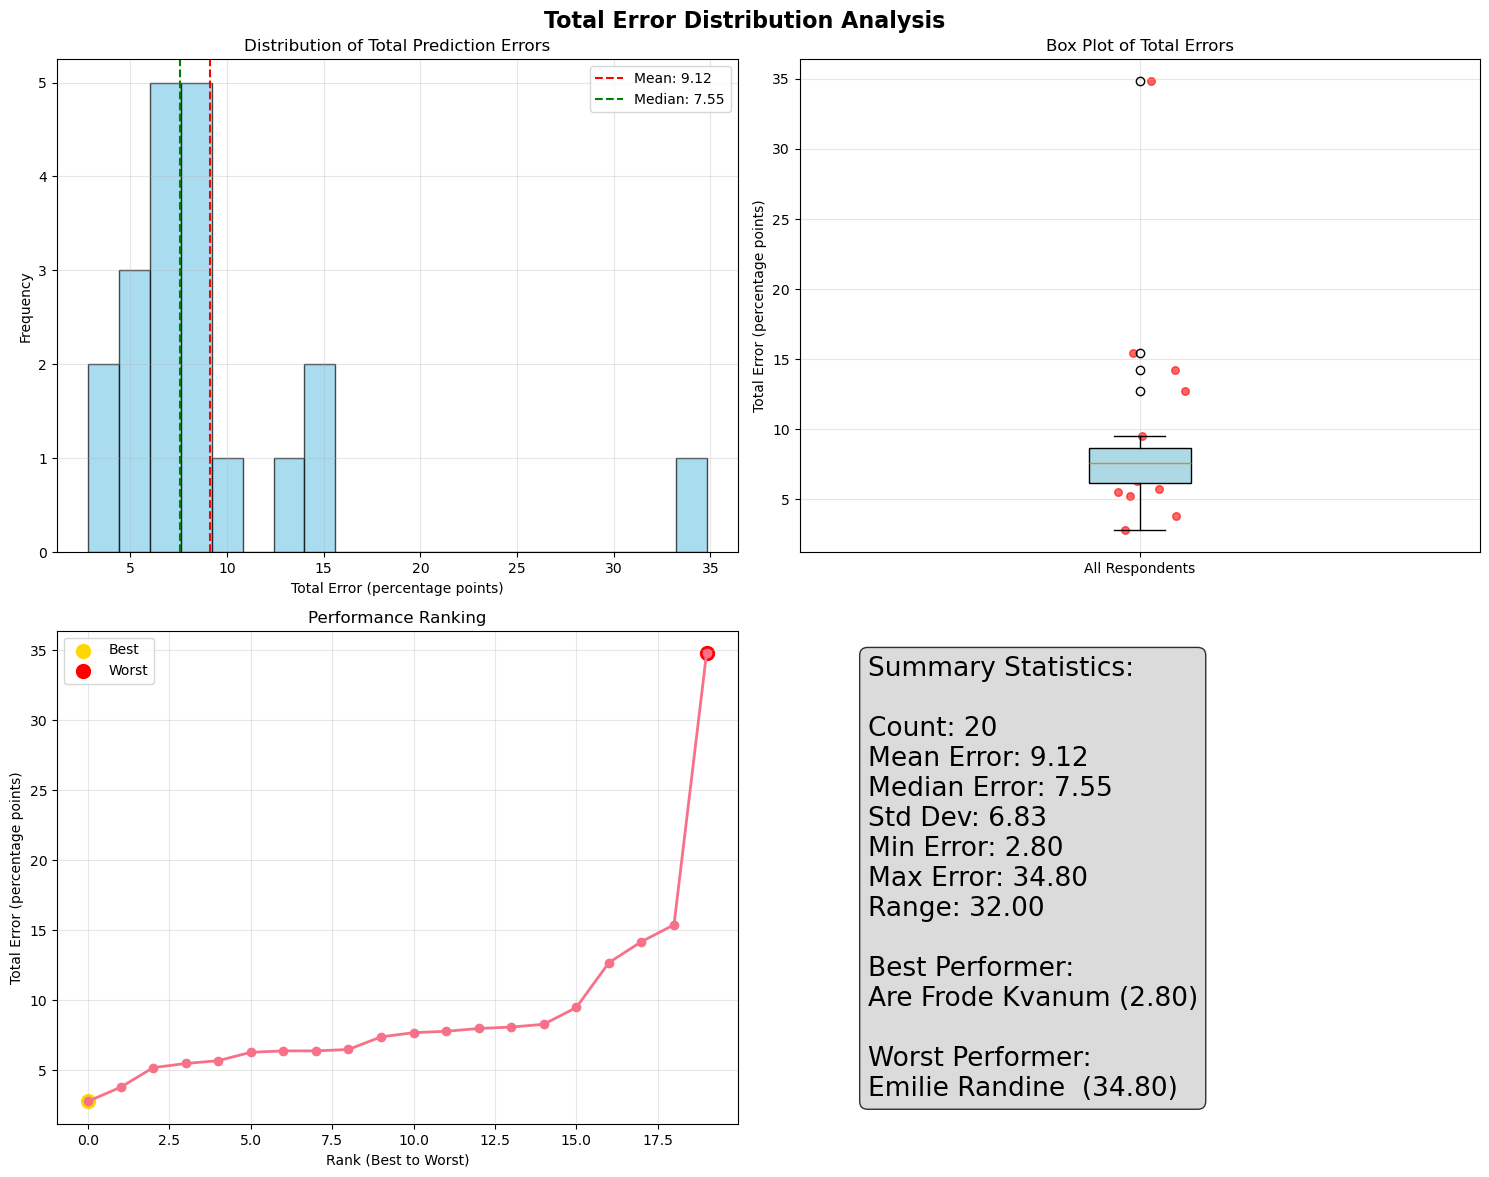

In [24]:
fig = create_error_distribution_plots(error_df)
plt.show()

## Compute Party-by-party error analysis

In [25]:
party_errors_df, party_stats = calculate_party_errors(preds, results)

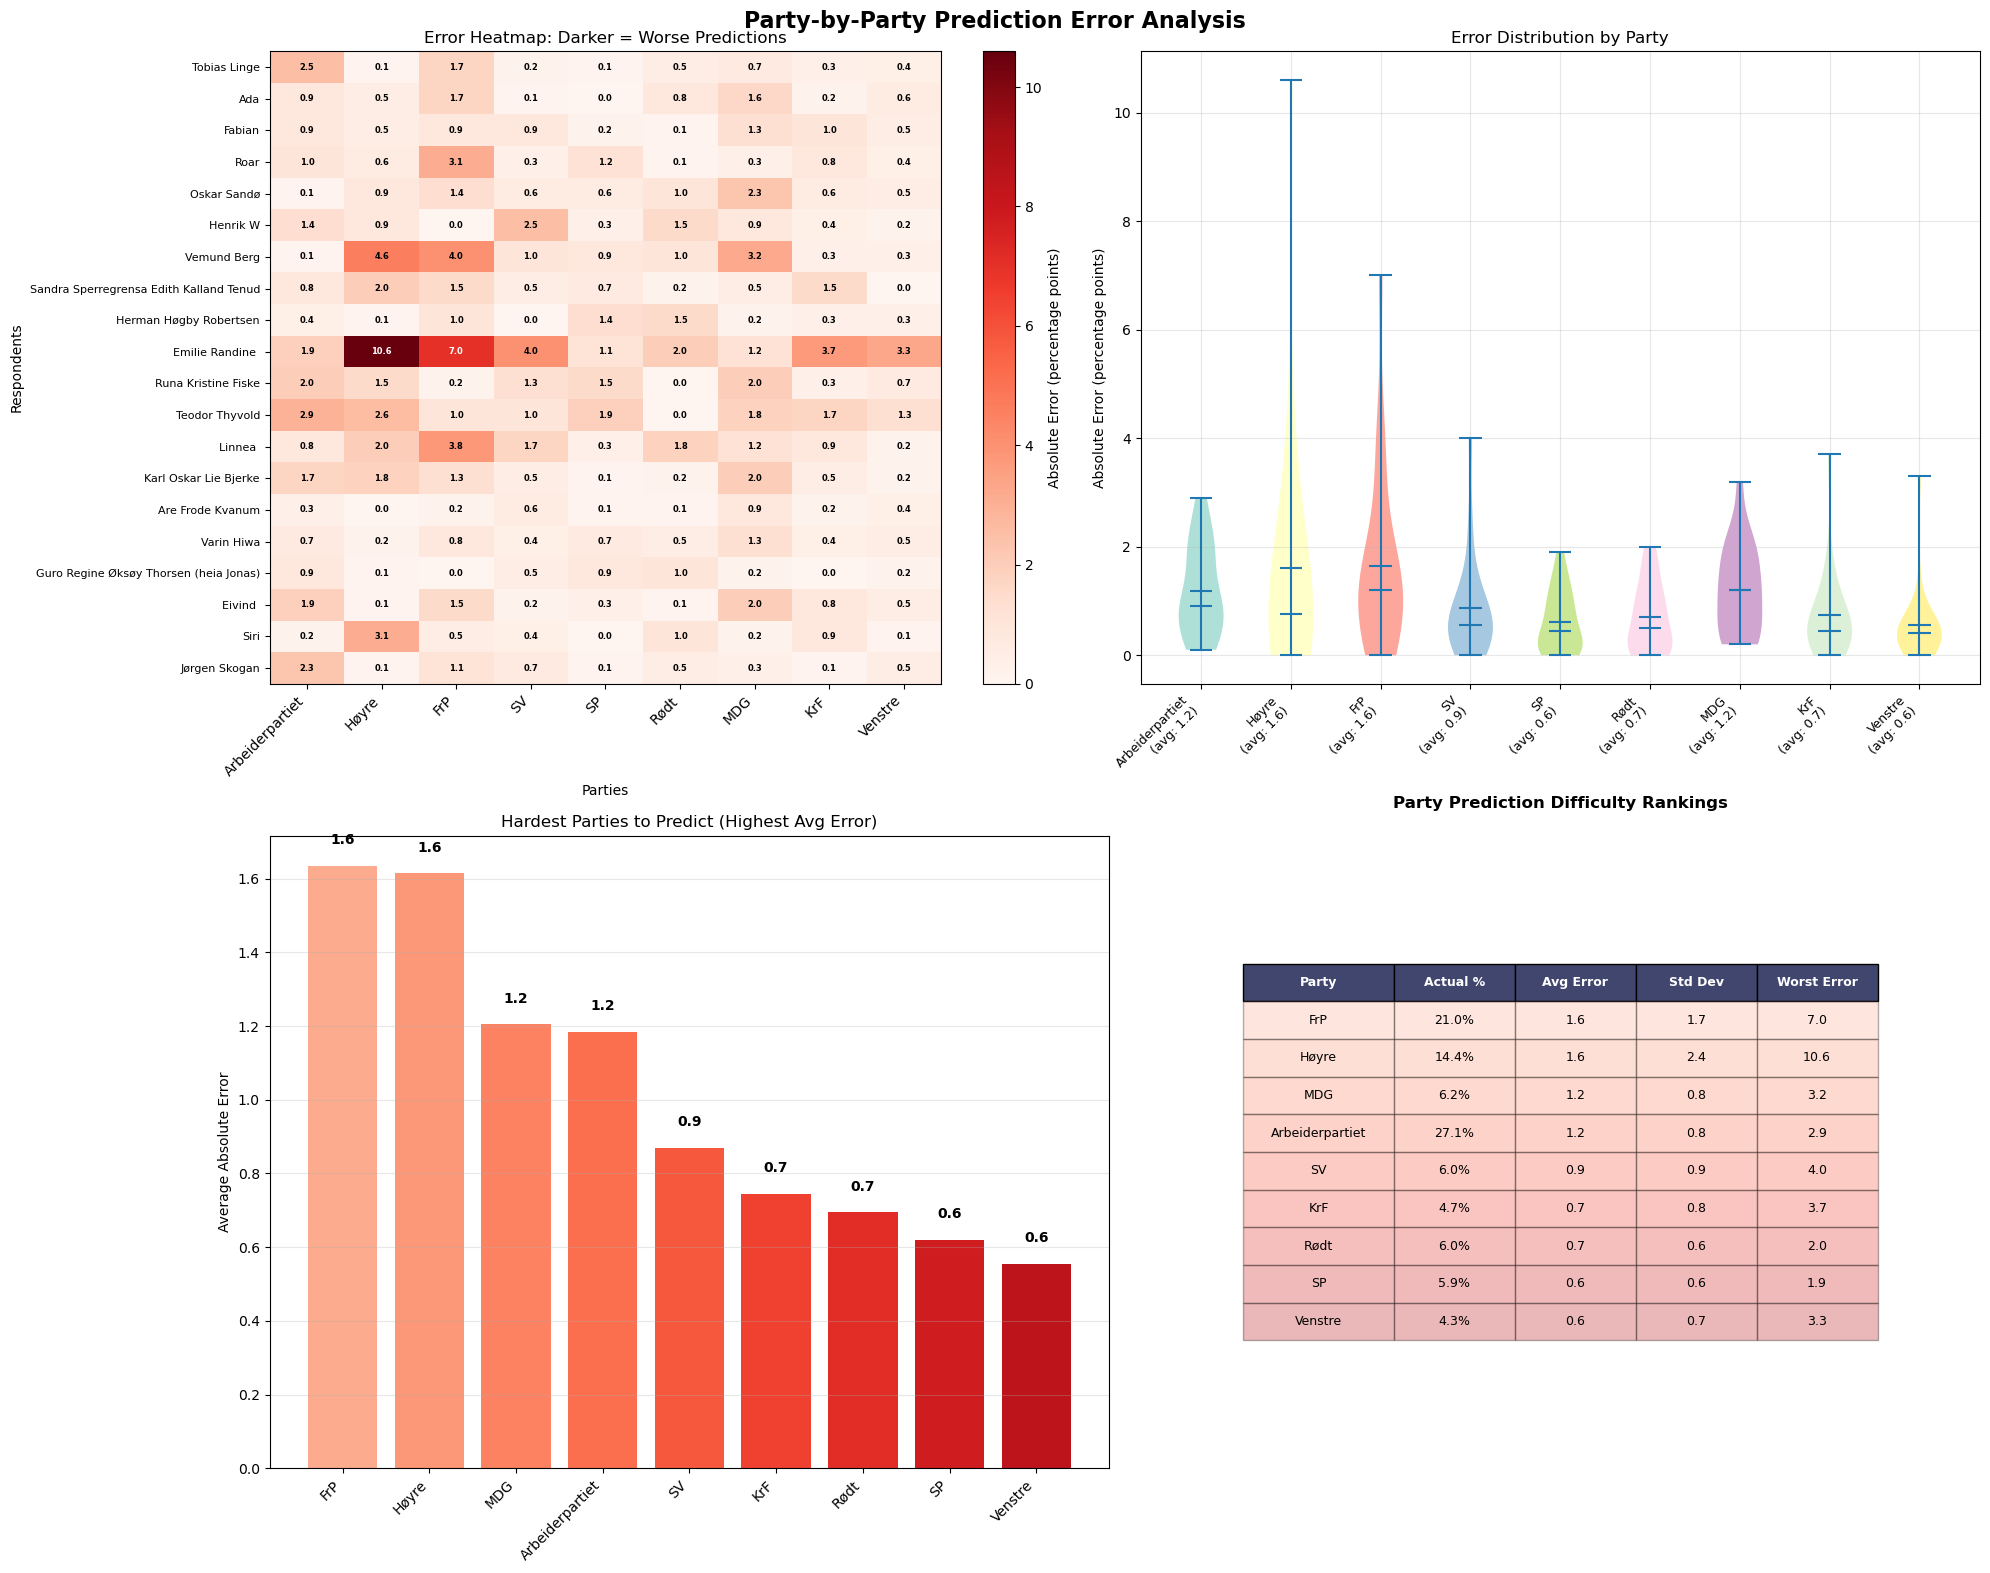

In [26]:
# Create comprehensive plots
fig, stats = create_party_analysis_plots(party_errors_df, party_stats)
plt.show()

In [27]:
# Get text insights
insights = get_party_insights(party_errors_df, party_stats)
print(insights)


PARTY PREDICTION INSIGHTS:

🎯 EASIEST TO PREDICT: Venstre (avg error: 0.6)
😰 HARDEST TO PREDICT: FrP (avg error: 1.6)

📊 MOST CONSISTENT PREDICTIONS: SP (std: 0.6)
📈 MOST INCONSISTENT PREDICTIONS: Høyre (std: 2.4)

🏆 BEST AT HARDEST PARTY (FrP): Henrik W (0.0 error)
🤦 WORST AT HARDEST PARTY (FrP): Emilie Randine  (7.0 error)

DIFFICULTY RANKING (hardest first):
1. FrP: 1.6 avg error (actual: 21.0%)
2. Høyre: 1.6 avg error (actual: 14.4%)
3. MDG: 1.2 avg error (actual: 6.2%)
4. Arbeiderpartiet: 1.2 avg error (actual: 27.1%)
5. SV: 0.9 avg error (actual: 6.0%)
6. KrF: 0.7 avg error (actual: 4.7%)
7. Rødt: 0.7 avg error (actual: 6.0%)
8. SP: 0.6 avg error (actual: 5.9%)
9. Venstre: 0.6 avg error (actual: 4.3%)



In [28]:
# Find who was best/worst at specific parties
print("Who was best at predicting each party:")
for party in party_errors_df.columns:
    if party != 'respondent':
        best_idx = party_errors_df[party].idxmin()
        best_person = party_errors_df.loc[best_idx, 'respondent']
        best_error = party_errors_df.loc[best_idx, party]
        print(f"{party}: {best_person} ({best_error:.1f} error)")

Who was best at predicting each party:
Arbeiderpartiet: Oskar Sandø (0.1 error)
Høyre: Are Frode Kvanum (0.0 error)
FrP: Henrik W (0.0 error)
SV: Herman Høgby Robertsen (0.0 error)
SP: Ada (0.0 error)
Rødt: Runa Kristine Fiske (0.0 error)
MDG: Herman Høgby Robertsen (0.2 error)
KrF: Guro Regine Øksøy Thorsen (heia Jonas) (0.0 error)
Venstre: Sandra Sperregrensa Edith Kalland Tenud (0.0 error)


## Bias detection plots

In [29]:
bias_df, party_bias_stats, respondent_bias_stats = calculate_prediction_bias(preds, results)

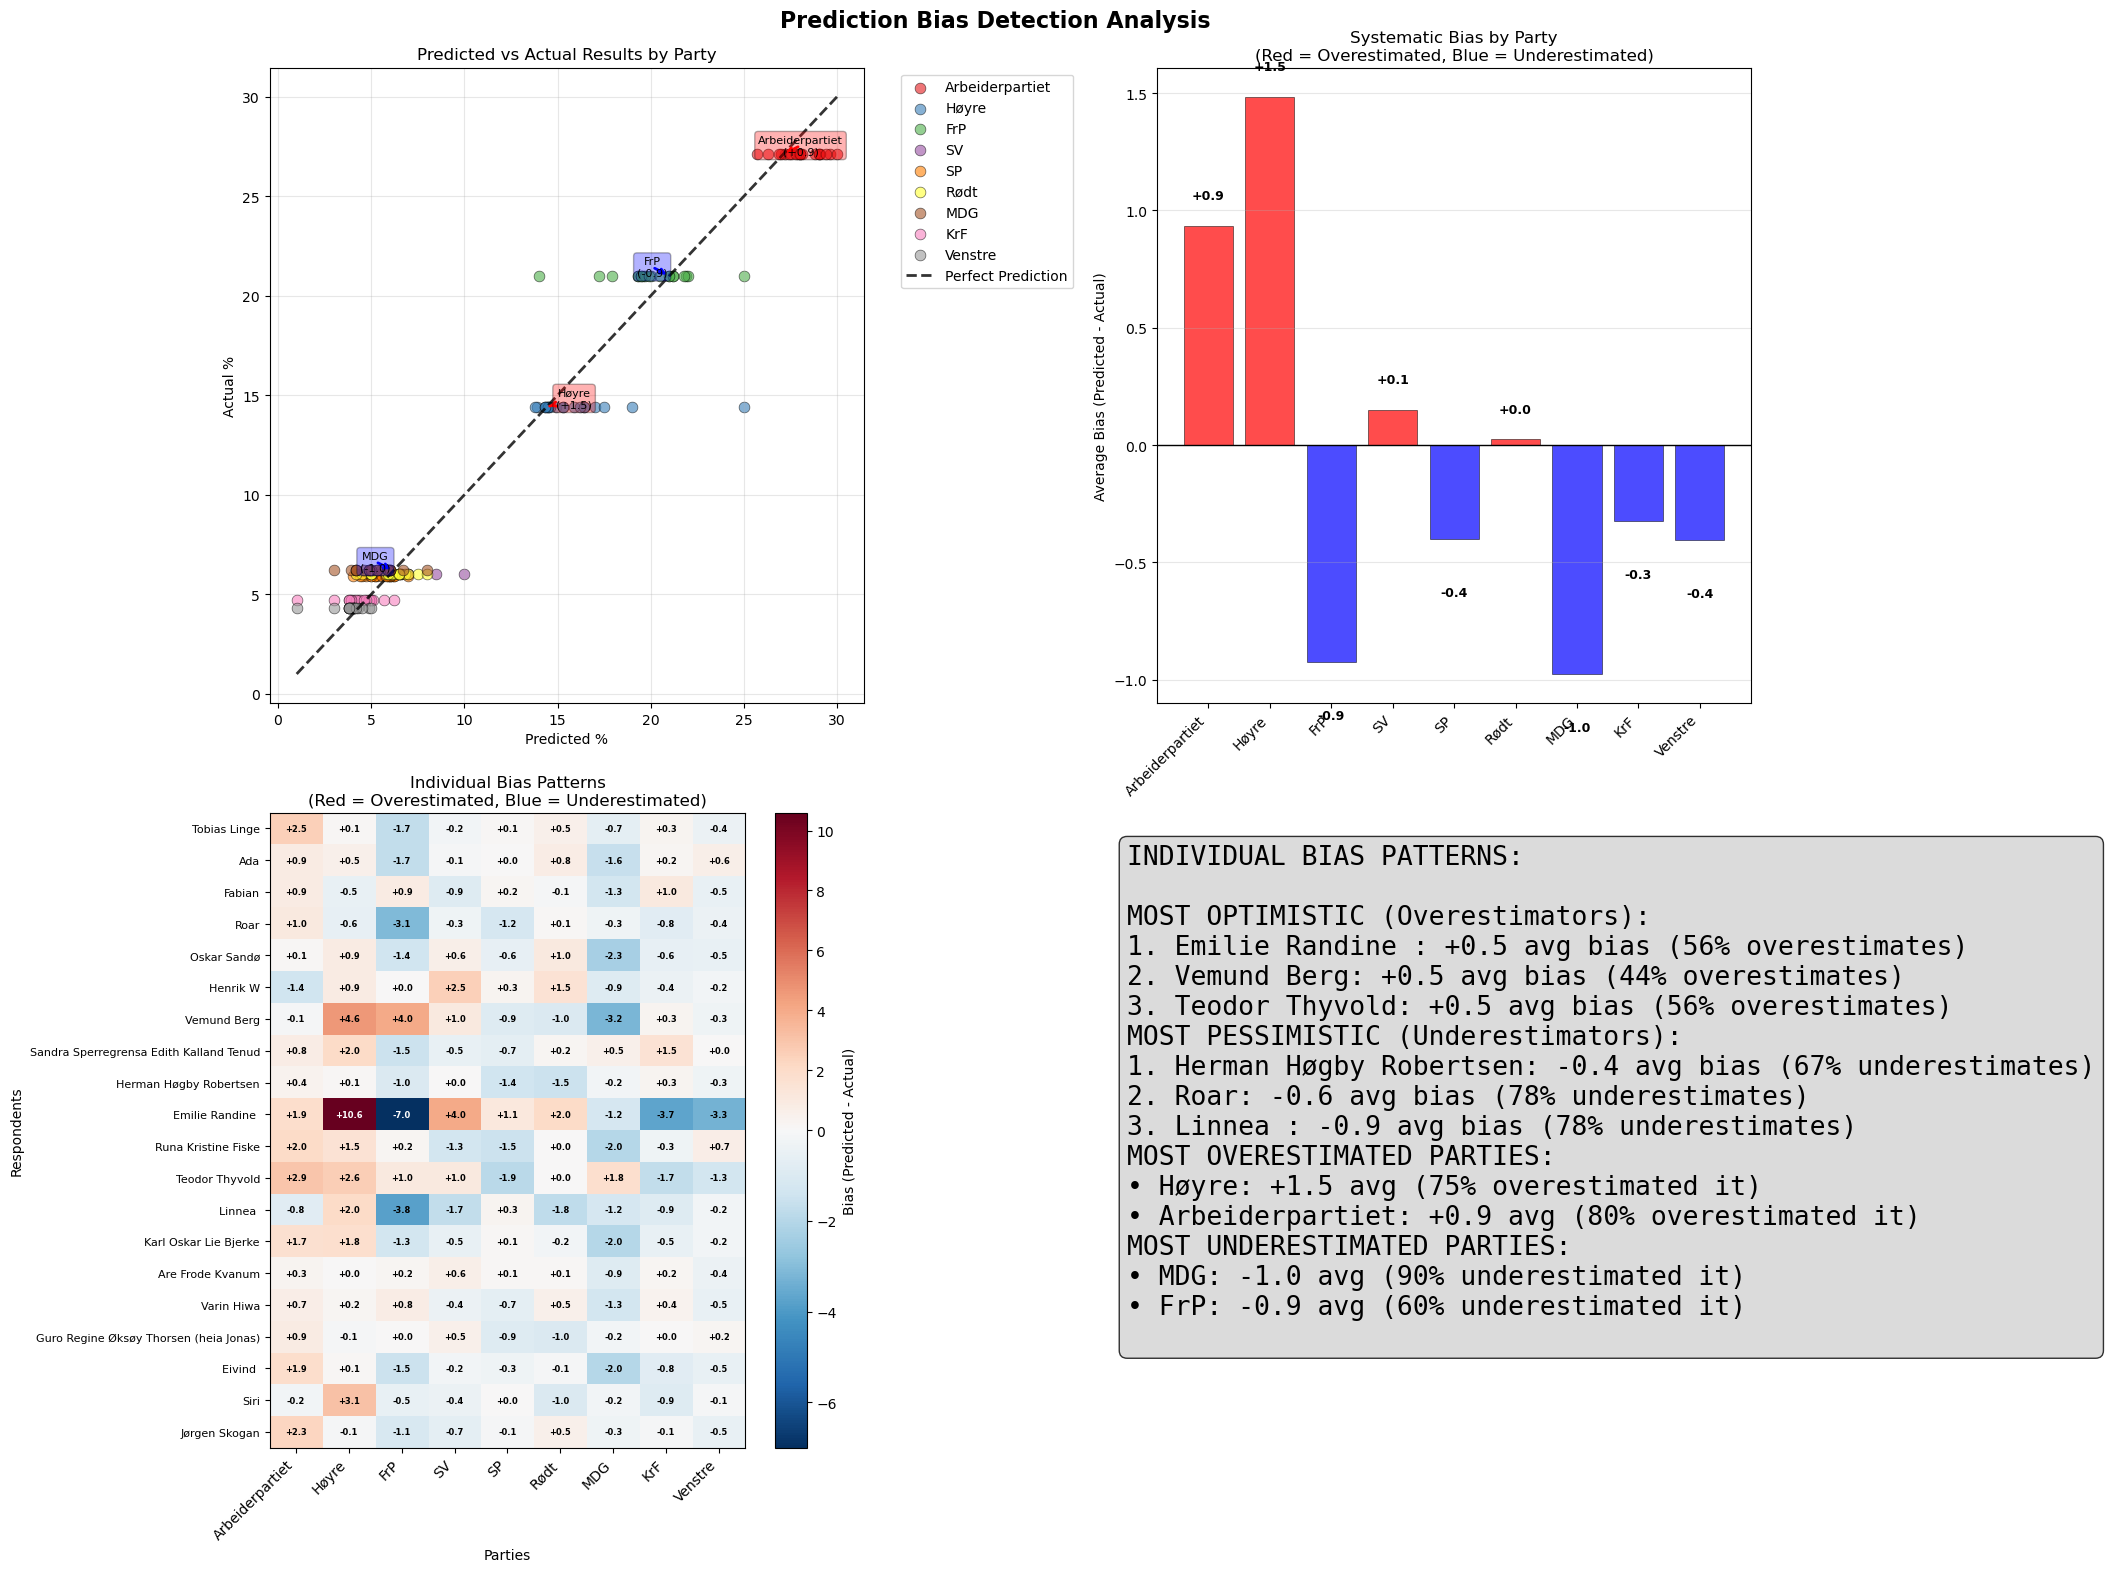

In [30]:
# Create bias detection plots
fig = create_bias_detection_plots(bias_df, party_bias_stats, respondent_bias_stats, 
                                preds, results)
plt.show()

In [31]:
# Get insights
bias_insights = get_bias_insights(bias_df, party_bias_stats, respondent_bias_stats)
print(bias_insights)

🎯 BIAS DETECTION INSIGHTS:

📊 OVERALL: Group predictions were remarkably unbiased (avg: -0.05)

🔴 BIGGEST OVERESTIMATE: Høyre (+1.5 on average)
   → 15/20 people overestimated it

🔵 BIGGEST UNDERESTIMATE: MDG (-1.0 on average)
   → 18/20 people underestimated it

😊 MOST OPTIMISTIC PERSON: Emilie Randine  (+0.5 avg bias)
😔 MOST PESSIMISTIC PERSON: Linnea  (-0.9 avg bias)



In [32]:
# Check specific patterns
print("\\nWho consistently overestimated small parties?")
small_parties = ['MDG', 'Rødt', 'Venstre']  # Adjust to your parties
for party in small_parties:
    if party in bias_df.columns:
        overestimators = bias_df[bias_df[party] > 1]['respondent'].tolist()
        print(f"{party}: {overestimators}")

\nWho consistently overestimated small parties?
MDG: ['Teodor Thyvold']
Rødt: ['Henrik W', 'Emilie Randine ']
Venstre: []


## Political clustering

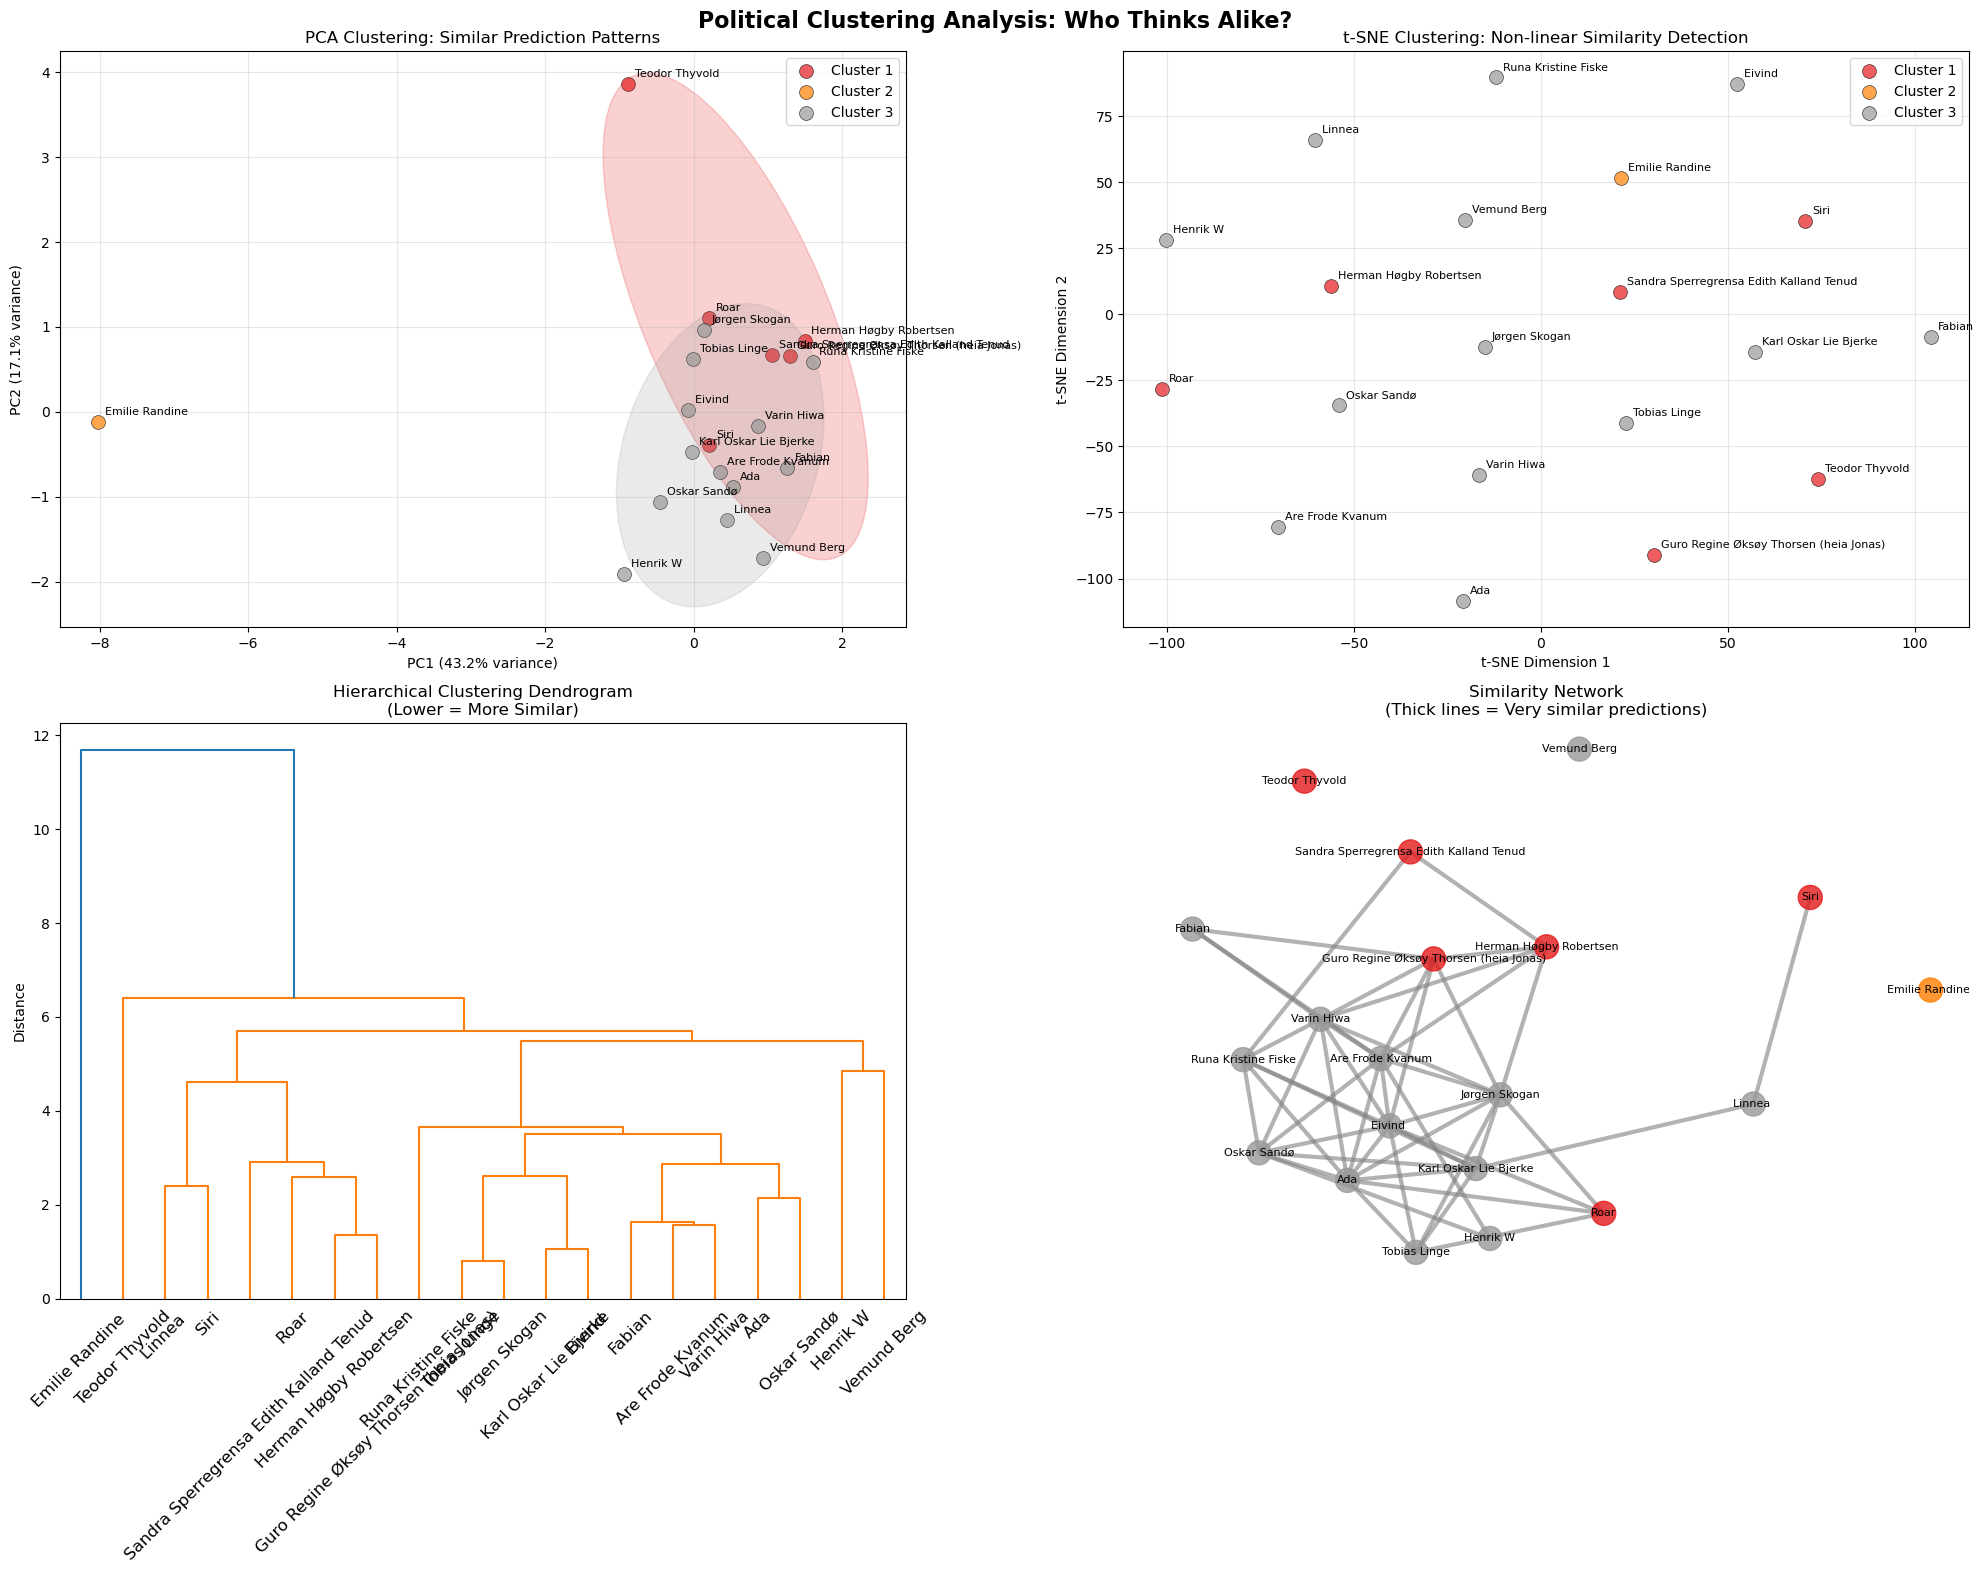

In [41]:
# Perform clustering analysis
fig, clustering_results, network, similarity_matrix, correlation_matrix = create_political_clustering_plots(preds, n_clusters=3)

plt.show()

In [38]:
# Analyze cluster characteristics  
cluster_analysis = analyze_cluster_characteristics(preds, clustering_results, partier)
# Get insights

respondent_names = preds['Eget navn'].values
clustering_insights = get_clustering_insights(preds, clustering_results, 
                                            cluster_analysis, correlation_matrix, respondent_names)
print(clustering_insights)

🎭 POLITICAL CLUSTERING INSIGHTS:

📊 PCA Analysis: First 2 components explain 60.3% of prediction variance
   → Moderate clustering patterns found

🎯 Found 3 distinct prediction groups:

🎭 The Realists (6 members):
   Members: Roar, Sandra Sperregrensa Edith Kalland Tenud, Herman Høgby Robertsen, Teodor Thyvold, Guro Regine Øksøy Thorsen (heia Jonas), Siri
   Distinctive traits:
   • Predicts MDG 1.2pp higher than average
   • Predicts SP 0.6pp lower than average
   • Predicts Rødt 0.6pp lower than average
   Internal consistency: very consistent

🎭 The Optimists (1 members):
   Members: Emilie Randine 
   Distinctive traits:
   • Predicts Høyre 9.1pp higher than average
   • Predicts FrP 6.1pp lower than average
   • Predicts SV 3.9pp higher than average
   Internal consistency: very consistent

🎭 The Contrarians (13 members):
   Members: Tobias Linge, Ada, Fabian, Oskar Sandø, Henrik W, Vemund Berg, Runa Kristine Fiske, Linnea , Karl Oskar Lie Bjerke, Are Frode Kvanum, Varin Hiwa, Eiv

In [42]:
# Determine political archetypes
archetypes = find_political_archetypes(cluster_analysis, results)
print("\\nPolitical Archetypes:")
for cluster_id, archetype in archetypes.items():
    members = cluster_analysis[cluster_id]['members']
    print(f"Cluster {cluster_id+1}: {archetype} - {', '.join(members)}")

\nPolitical Archetypes:
Cluster 1: Balanced/Realistic - Roar, Sandra Sperregrensa Edith Kalland Tenud, Herman Høgby Robertsen, Teodor Thyvold, Guro Regine Øksøy Thorsen (heia Jonas), Siri
Cluster 2: Mixed Pattern - Emilie Randine 
Cluster 3: Balanced/Realistic - Tobias Linge, Ada, Fabian, Oskar Sandø, Henrik W, Vemund Berg, Runa Kristine Fiske, Linnea , Karl Oskar Lie Bjerke, Are Frode Kvanum, Varin Hiwa, Eivind , Jørgen Skogan
